Import Qiskit and other Python dependencies

In [1]:
%matplotlib inline
from qiskit import Aer
import networkx as nx
from qiskit import QuantumCircuit

# Classical Eigensolver
from qiskit.algorithms import NumPyMinimumEigensolver

# Variational Quantum Eigensolvers
from qiskit.algorithms import VQE, QAOA

# Classical Optimizers
from qiskit.algorithms.optimizers import COBYLA, ADAM
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo

# For running on real device
from qiskit.providers.ibmq import IBMQ

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime

Load Environment Variables

In [2]:
from dotenv import dotenv_values
config = dotenv_values('../.env')

Load Quandl API Token

In [3]:
import quandl
quandl.ApiConfig.api_key = config['QUANDL_API_TOKEN']

Select Companies

In [4]:
stocks = pd.DataFrame({
    'company': [
        'Apple',
        'Microsoft',
        'Amazon',
        'Alphabet/Google',
        'Tesla',
        'Facebook',
        'PayPal',
        'Netflix',
        'Intel',
        'Adobe',
        'PepsiCo',
        'Starbucks',
        'Nvidia'
    ],
    'ticker': [
        'AAPL',
        'MSFT',
        'AMZN',
        'GOOG',
        'TSLA',
        'FB',
        'PYPL',
        'NFLX',
        'INTC',
        'ADBE',
        'PEP',
        'SBUX',
        'NVDA'
    ]
})
stocks

,company,ticker
0,Apple,AAPL
1,Microsoft,MSFT
2,Amazon,AMZN
3,Alphabet/Google,GOOG
4,Tesla,TSLA
5,Facebook,FB
6,PayPal,PYPL
7,Netflix,NFLX
8,Intel,INTC
9,Adobe,ADBE


Load Stock Data

In [5]:
try:
    wiki = WikipediaDataProvider(
        token = quandl.ApiConfig.api_key,
        tickers = stocks['ticker'].to_list(),
        start = datetime.datetime(2016, 1, 1),
        end = datetime.datetime(2016, 1, 30)
    )
    wiki.run()
except QiskitFinanceError as e:
    print(e)
    print("Error retrieving data.")

View Time-Series Similarity and Covariance. [To determine which is best for modeling it is best to test with both and compare results.](https://stats.stackexchange.com/questions/256015/whats-the-difference-between-applying-correlation-and-dtw-in-a-time-series)

A time-series similarity measure:
[[1.00000000e+00 1.16448071e-03 1.04022259e-04 8.44268222e-05
  4.80806898e-04 1.68437309e-02 8.45406476e-04 7.31192666e-03
  7.98641591e-04 1.03967106e-02 2.20395124e-02 1.36042452e-03
  7.94690582e-04]
 [1.16448071e-03 1.00000000e+00 9.54920228e-05 7.87195235e-05
  3.40299383e-04 1.07230679e-03 3.08536208e-03 9.47491058e-04
  2.54210850e-03 1.35578710e-03 1.24781852e-03 8.08490987e-03
  2.50250559e-03]
 [1.04022259e-04 9.54920228e-05 1.00000000e+00 4.48179272e-04
  1.32740602e-04 1.04827187e-04 9.26252687e-05 1.06194765e-04
  9.20348175e-05 1.02727413e-04 1.03405341e-04 9.66333733e-05
  9.19821172e-05]
 [8.44268222e-05 7.87195235e-05 4.48179272e-04 1.00000000e+00
  1.02409281e-04 8.49562815e-05 7.67610521e-05 8.58523117e-05
  7.63550939e-05 8.35718614e-05 8.40199843e-05 7.94935200e-05
  7.63188172e-05]
 [4.80806898e-04 3.40299383e-04 1.32740602e-04 1.02409281e-04
  1.00000000e+00 4.98499516e-04 3.06494621e-04 5.31019504e-04
  3.00123365e-04 4.5433687

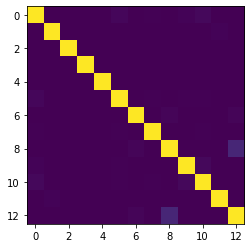

A covariance matrix:
[[ 7.86304499e+00  2.52395698e+00  3.24361517e+01  2.54225233e+01
   2.01938623e+01  2.24515466e+00  1.14468872e+00  8.72602718e+00
   2.60078275e+00  4.48477036e+00  2.00579262e+00  4.63474296e-01
   3.08865601e+00]
 [ 2.52395698e+00  1.89582761e+00  2.12030299e+01  2.01878706e+01
   7.19332441e+00  5.05463274e+00  1.57059688e+00  1.47570854e+00
   1.52345065e+00  1.71311245e+00  1.97777347e+00  5.32422430e-01
   1.82829107e+00]
 [ 3.24361517e+01  2.12030299e+01  5.20333636e+02  3.00348446e+02
   1.31678358e+02  6.34447743e+01  1.85627316e+01  6.32497313e+01
   2.24630367e+01  1.51522398e+01  2.98258274e+01  1.69164747e+00
   2.89699233e+01]
 [ 2.54225233e+01  2.01878706e+01  3.00348446e+02  2.69601181e+02
   8.20839482e+01  6.63669871e+01  1.82832936e+01  2.11002295e+01
   1.52782539e+01  1.67787254e+01  2.41715127e+01  6.85891087e+00
   2.05389077e+01]
 [ 2.01938623e+01  7.19332441e+00  1.31678358e+02  8.20839482e+01
   1.14728362e+02  5.08711988e-01  4.62116433

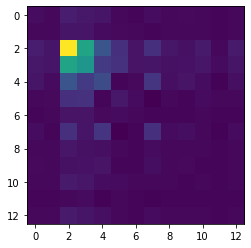

In [6]:
if wiki._data:
    if wiki._n <= 1:
        print("At least two tickers are needed to plot covariance and/or time-series similarity.")
    else:
        rho = wiki.get_similarity_matrix() # ρ
        print("A time-series similarity measure:")
        print(rho)
        plt.imshow(rho)
        plt.show()
        
        cov = wiki.get_covariance_matrix()
        print("A covariance matrix:")
        print(cov)
        plt.imshow(cov)
        plt.show()
else:
    print("No data loaded.")

View Evolution of Stock Prices over time series.

The underlying evolution of stock prices:


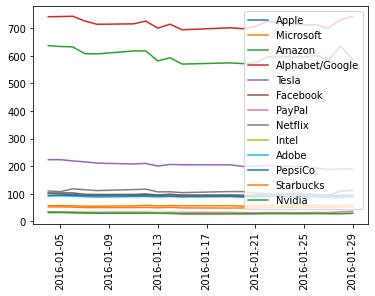

Company: Apple, Ticker: AAPL
Date
2016-01-04    101.783763
2016-01-05     99.233131
2016-01-06     97.291172
2016-01-07     93.185040
2016-01-08     93.677776
2016-01-11     95.194629
2016-01-12     96.576222
2016-01-13     94.093220
2016-01-14     96.151117
2016-01-15     93.842021
2016-01-19     93.387931
2016-01-20     93.513531
2016-01-21     93.040118
2016-01-22     97.986799
2016-01-25     96.073825
2016-01-26     96.605206
2016-01-27     90.257610
2016-01-28     90.904929
2016-01-29     94.044912
Name: Adj. Close, dtype: float64

Company: Microsoft, Ticker: MSFT
Date
2016-01-04    52.181598
2016-01-05    52.419653
2016-01-06    51.467434
2016-01-07    49.677262
2016-01-08    49.829617
2016-01-11    49.801050
2016-01-12    50.258116
2016-01-13    49.172586
2016-01-14    50.572348
2016-01-15    48.553644
2016-01-19    48.144190
2016-01-20    48.363200
2016-01-21    48.068012
2016-01-22    49.791528
2016-01-25    49.315419
2016-01-26    49.677262
2016-01-27    48.772654
2016-01-28 

In [7]:
if wiki._data:
    print("The underlying evolution of stock prices:")
    for cnt in range(len(stocks)):
        plt.plot(wiki._data[cnt], label=stocks['company'][cnt])
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
    
    for cnt in range(len(stocks)):
        print(f"Company: {stocks['company'][cnt]}, Ticker: {stocks['ticker'][cnt]}")
        print(wiki._data[cnt])
        print()
else:
    print("No data loaded.")

Set Porfolio Optimization Parameters

In [8]:
num_of_assets = len(stocks)
seed = 123

mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()
q = 0.5 # risk factor
budget = 4 # set budget
penalty = num_of_assets # set parameter to scale the budget penalty term

Create Portfolio Optimization Quadratic Program

In [9]:
portfolio = PortfolioOptimization(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: 0.004003851233 x_0 - 0.000570854424 x_1 + 0.003891398085 x_2
      - 0.000286581326 x_3 + 0.008435623591 x_4 - 0.006069018811 x_5
      - 0.002573138646 x_6 + 0.009129426904 x_7 + 0.004678902024 x_8
      + 0.001552515305 x_9 - 0.000373384726 x_10 - 0.002569447077 x_11
      + 0.005225912434 x_12 + [ 0.000798336105 x_0^2 + 0.001125375553 x_0*x_1
      + 0.000772373590 x_0*x_2 + 0.000808809127 x_0*x_3 + 0.000649033545 x_0*x_4
      + 0.001352498471 x_0*x_5 + 0.000925391952 x_0*x_6 + 0.000705589675 x_0*x_7
      + 0.000932029354 x_0*x_8 + 0.000846816125 x_0*x_9
      + 0.000348428641 x_0*x_10 + 0.000715494000 x_0*x_11
      + 0.000819449511 x_0*x_12 + 0.000592682404 x_1^2 + 0.000419643603 x_1*x_2
      + 0.000740538743 x_1*x_3 + 0.000550857352 x_1*x_4 + 0.001307399726 x_1*x_5
      + 0.000982260632 x_1*x_6 + 0.000245034564 x_1*x_7 + 0.001107216294 x_1*x_8
      + 0.000776

In [10]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print(f'Optimal: selection {selection}, value {value:.4f}')
    for cnt, val in enumerate(selection):
        if val == 1:
            print(stocks['company'][cnt])

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    cnt = 0
    for i in i_sorted:
        if cnt == 20:
            break
        cnt += 1
        x = index_to_selection(i, num_of_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [11]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.], value -0.0069
Facebook
PayPal
PepsiCo
Starbucks

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 1 1 0 0 0 1 1 0]	-0.0069		1.0000
[1 1 1 1 1 0 0 1 0 1 0 1 0]	17.3763		0.0000
[0 0 0 0 0 1 0 1 0 1 0 1 0]	0.0067		0.0000
[1 0 0 0 0 1 0 1 0 1 0 1 0]	1.0967		0.0000
[0 1 0 0 0 1 0 1 0 1 0 1 0]	1.0917		0.0000
[1 1 0 0 0 1 0 1 0 1 0 1 0]	4.3498		0.0000
[0 0 1 0 0 1 0 1 0 1 0 1 0]	1.0974		0.0000
[1 0 1 0 0 1 0 1 0 1 0 1 0]	4.3553		0.0000
[0 1 1 0 0 1 0 1 0 1 0 1 0]	4.3502		0.0000
[1 1 1 0 0 1 0 1 0 1 0 1 0]	9.7762		0.0000
[0 0 0 1 0 1 0 1 0 1 0 1 0]	1.0923		0.0000
[1 0 0 1 0 1 0 1 0 1 0 1 0]	4.3502		0.0000
[0 1 0 1 0 1 0 1 0 1 0 1 0]	4.3452		0.0000
[1 1 0 1 0 1 0 1 0 1 0 1 0]	9.7712		0.0000
[0 0 1 1 0 1 0 1 0 1 0 1 0]	4.3510		0.0000
[1 0 1 1 0 1 0 1 0 1 0 1 0]	9.7769		0.0000
[1 1 1 1 1 1 1 1 1 1 1 1 1]	87.8443		0.0000
[1 1 1 1 0 1 0 1 0 1 0 

In [12]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_of_assets, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

C:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:137: UserWarning: The sum of probability of samples is not close to 1: 0.9998843539343966
  warn('The sum of probability of samples is not close to 1: {}'.format(sum_prob))


Optimal: selection [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.], value -0.0058
Alphabet/Google
Facebook
PayPal
Starbucks

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1 0 0 0 0 0 1 0 1]	0.0151		0.2376
[0 0 0 0 1 1 0 1 0 0 0 0 1]	0.0211		0.2217
[0 0 0 0 0 1 1 1 0 0 0 1 0]	0.0040		0.2204
[0 0 0 1 0 0 1 0 0 0 1 1 0]	-0.0029		0.1986
[0 0 0 1 0 0 0 0 0 0 1 1 1]	0.0044		0.0330
[0 0 0 0 0 1 0 1 0 0 0 1 1]	0.0104		0.0302
[0 0 0 1 1 0 1 0 0 0 1 0 0]	0.0078		0.0142
[0 0 0 0 1 1 1 1 0 0 0 0 0]	0.0148		0.0140
[0 0 0 0 0 1 1 0 0 0 0 1 0]	1.0764		0.0024
[0 0 0 0 0 1 1 1 0 1 0 1 0]	1.0907		0.0018
[0 0 0 0 1 1 0 0 0 0 0 0 1]	1.0939		0.0016
[0 0 0 0 1 1 0 1 0 1 0 0 1]	1.1077		0.0014
[0 0 0 1 1 0 0 0 0 1 1 0 1]	1.1016		0.0012
[0 0 0 0 0 1 1 1 0 0 0 0 1]	0.0113		0.0012
[0 0 0 1 0 0 0 0 0 0 1 1 0]	1.0818		0.0009
[0 0 0 1 0 0 1 0 0 0 1 0 1]	0.0048		0.0009
[0 0 0 0 0 1 0 1 0 0 0 0 0]	4.3408		0.0008
[0 0 0 1 0 0 1 0 

In [13]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.], value -0.0069
Facebook
PayPal
PepsiCo
Starbucks

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0]	17.3404		0.0064
[0 0 0 0 0 0 0 1 0 0 0 0 0]	9.7640		0.0018
[0 0 0 0 1 0 0 0 0 0 0 0 0]	9.7626		0.0018
[0 0 0 0 0 0 0 0 1 0 0 0 0]	9.7590		0.0018
[1 0 0 0 0 0 0 0 0 0 0 0 0]	9.7584		0.0017
[0 0 1 0 0 0 0 0 0 0 0 0 0]	9.7585		0.0017
[0 0 0 0 0 0 0 0 0 0 0 0 1]	9.7595		0.0017
[0 0 0 1 0 0 0 0 0 0 0 0 0]	9.7539		0.0017
[0 0 0 0 0 0 0 0 0 1 0 0 0]	9.7557		0.0017
[0 1 0 0 0 0 0 0 0 0 0 0 0]	9.7537		0.0017
[0 0 0 0 0 1 0 0 0 0 0 0 0]	9.7489		0.0017
[0 0 0 0 0 0 1 0 0 0 0 0 0]	9.7518		0.0017
[0 0 0 0 0 0 0 0 0 0 0 1 0]	9.7516		0.0017
[0 0 0 0 0 0 0 0 0 0 1 0 0]	9.7537		0.0017
[1 1 1 1 1 1 1 1 1 1 1 1 1]	87.8443		0.0016
[0 0 0 0 1 0 0 1 0 0 0 0 0]	4.3539		0.0007
[0 0 0 0 0 0 0 1 1 0 0 0 0]	4.3504		0.0007
[0 0 0 0 0 0 0 1 0 0 0 0